MPNN Pipeline: Train on Idealized -> Test on Realistic

Multi-output MPNN to predict both TAWSS and OSI on AV graft meshes, training on idealized meshes and testing on realistic ones.

Hypothesis: Applying nonlinearity to the edge representations (i.e. applying a transformation to edge features) before aggregating to the nodes will improve performance. Performance should beat previous augmented GNN model. Result: (HuberLoss down to 0.5588 from 0.5713)

Experiment:
Let's try ramping up the edge features from 16 to 64, adding another GCNConv Layer and setting hidden number from 128 to 256.

In [ ]:
%pip install torch torch-geometric meshio numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

In [ ]:
!pip install tqdm trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.1/711.1 kB 14.2 MB/s eta 0:00:00


In [ ]:
!pwd
!ls
!unzip data.zip -d .

/content
data.zip  sample_data
Archive:  data.zip
   creating: ./data/
   creating: ./data/Realistic/
   creating: ./data/Idealized/
  inflating: ./data/Data description.txt  
   creating: ./data/Realistic/derived_cfd_metrics/
   creating: ./data/Idealized/derived_cfd_metrics/
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rZCRCZ_turb_metric.h5  
  inflating: ./data/Realistic/derived_cfd_metrics/turbulenceZCRCZ.xdmf  
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rBlock_wss_metrics.h5  
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rZCRCZR_turb_metric.h5  
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rBlock_turb_metric.h5  
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rZCRCZR_wss_metrics.h5  
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.h5  
  inflating: ./data/Realistic/derived_cfd_metrics/turbulenceBlock.xdmf  
  inflating: ./data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.xdmf  
  inflating: ./data/Realis

In [ ]:
import meshio, numpy as np, torch
import matplotlib.pyplot as plt
import torch_geometric

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
from collections import defaultdict
import trimesh


def build_edge_index(triangles, num_nodes):
    # Undirected edges from triangle list
    edges = set()
    for i, j, k in triangles:
        edges |= {(i, j), (j, k), (k, i)}
    edge_idx = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    return edge_idx

def angle_between_vectors_numpy(v1, v2, normalize=True, epsilon=1e-8):
    """Computes the angle in radians between pairs of vectors in NumPy arrays."""
    if normalize:
        v1_norm = np.linalg.norm(v1, axis=1, keepdims=True)
        v2_norm = np.linalg.norm(v2, axis=1, keepdims=True)
        v1 = v1 / (v1_norm + epsilon)
        v2 = v2 / (v2_norm + epsilon)
    dot_product = np.sum(v1 * v2, axis=1)
    dot_product = np.clip(dot_product, -1.0 + epsilon, 1.0 - epsilon)
    return np.arccos(dot_product)

def load_graph_with_edge_features(xdmf_path):
    """
    Loads a graph from an XDMF file and computes node and edge features.
    Handles non-triangular meshes by triangulating them.
    Node features: [coords (3), degree (1)].
    Edge features: [dihedral_angle (1), min_inner_angle (1), max_inner_angle (1),
                    min_edge_ratio (1), max_edge_ratio (1)].
    """
    # Load mesh
    mesh = meshio.read(xdmf_path)
    pts_np = mesh.points.astype(np.float32)

    # Check for triangular or non-triangular mesh
    if "triangle" in mesh.cells_dict:
        triangles_np = mesh.cells_dict["triangle"].astype(np.int64)
    else:
        # Handle non-triangular meshes (e.g., quads)
        faces = mesh.cells_dict.get("quad", None)
        if faces is None:
            raise ValueError(f"No triangle or quad cells found in {xdmf_path}. Available cells: {mesh.cells_dict.keys()}")
        # Triangulate using trimesh
        tri_mesh = trimesh.Trimesh(vertices=pts_np, faces=faces)
        tri_mesh.process(validate=True)
        tri_mesh = tri_mesh.subdivide()  # Subdivide ensures triangulation
        pts_np = tri_mesh.vertices.astype(np.float32)
        triangles_np = tri_mesh.faces.astype(np.int64)

    num_nodes = pts_np.shape[0]

    # 1. Compute unit normals for all faces
    v0 = pts_np[triangles_np[:, 0]]
    v1 = pts_np[triangles_np[:, 1]]
    v2 = pts_np[triangles_np[:, 2]]
    vec1 = v1 - v0
    vec2 = v2 - v0
    normals_np = np.cross(vec1, vec2)
    norms = np.linalg.norm(normals_np, axis=1, keepdims=True)
    unit_normals_np = normals_np / (norms + 1e-8)

    # 2. Build edge_index and edge_to_faces map
    edge_set = set()
    edge_to_faces = defaultdict(list)
    for i, face_v_indices in enumerate(triangles_np):
        e1 = tuple(sorted((face_v_indices[0], face_v_indices[1])))
        e2 = tuple(sorted((face_v_indices[1], face_v_indices[2])))
        e3 = tuple(sorted((face_v_indices[2], face_v_indices[0])))
        for edge in [e1, e2, e3]:
            edge_set.add(edge)
            edge_to_faces[edge].append(i)
    unique_edges_list = list(edge_set)
    num_edges = len(unique_edges_list)
    unique_edges_np = np.array(unique_edges_list)

    # Create PyTorch edge_index (undirected)
    edge_index = torch.tensor([[v1, v2] for v1, v2 in unique_edges_list] +
                              [[v2, v1] for v1, v2 in unique_edges_list],
                              dtype=torch.long).t().contiguous()

    # 3. Generate edge-face pairs
    edge_face_pairs = [(e_idx, f_idx) for e_idx, edge in enumerate(unique_edges_list)
                       for f_idx in edge_to_faces[edge]]
    edge_indices = np.array([pair[0] for pair in edge_face_pairs])
    face_indices = np.array([pair[1] for pair in edge_face_pairs])
    num_pairs = len(edge_face_pairs)

    # 4. Extract vertices for all pairs
    edge_vertices = unique_edges_np[edge_indices]
    face_vertices = triangles_np[face_indices]

    # 5. Find opposite vertices
    diff0 = face_vertices != edge_vertices[:, 0][:, None]
    diff1 = face_vertices != edge_vertices[:, 1][:, None]
    opposite_mask = diff0 & diff1
    opposite_vertex_indices = face_vertices[np.arange(num_pairs), np.argmax(opposite_mask, axis=1)]

    # 6. Get coordinates
    p_edge_v1_np = pts_np[edge_vertices[:, 0]]
    p_edge_v2_np = pts_np[edge_vertices[:, 1]]
    p_opposite_v_np = pts_np[opposite_vertex_indices]

    # 7. Compute inner angles
    vec_opp_to_e1 = p_edge_v1_np - p_opposite_v_np
    vec_opp_to_e2 = p_edge_v2_np - p_opposite_v_np
    inner_angles_rad = angle_between_vectors_numpy(vec_opp_to_e1, vec_opp_to_e2)

    # 8. Compute edge length ratios
    edge_len = np.linalg.norm(p_edge_v2_np - p_edge_v1_np, axis=1)
    vec_edge = p_edge_v2_np - p_edge_v1_np
    vec_e1_to_opp = p_opposite_v_np - p_edge_v1_np
    area = 0.5 * np.linalg.norm(np.cross(vec_edge, vec_e1_to_opp), axis=1)
    height = np.where(area < 1e-9, 1e-7, (2 * area) / (edge_len + 1e-8))
    edge_length_ratio_val = np.where(edge_len < 1e-7, 1.0,
                                     np.where(height < 1e-7, edge_len / 1e-7, edge_len / height))

    # 9. Aggregate features per edge
    sort_idx = np.argsort(edge_indices)
    sorted_edge_indices = edge_indices[sort_idx]
    sorted_inner_angles = inner_angles_rad[sort_idx]
    sorted_edge_ratios = edge_length_ratio_val[sort_idx]
    _, counts = np.unique(sorted_edge_indices, return_counts=True)
    split_points = np.cumsum(counts[:-1])
    inner_groups = np.split(sorted_inner_angles, split_points)
    ratio_groups = np.split(sorted_edge_ratios, split_points)
    min_inner_angles = np.array([np.min(g) for g in inner_groups])
    max_inner_angles = np.array([np.max(g) for g in inner_groups])
    min_edge_ratios = np.array([np.min(g) for g in ratio_groups])
    max_edge_ratios = np.array([np.max(g) for g in ratio_groups])

    # 10. Compute dihedral angles for internal edges
    internal_edge_indices = [i for i, edge in enumerate(unique_edges_list)
                             if len(edge_to_faces[edge]) == 2]
    internal_edge_faces = np.array([edge_to_faces[unique_edges_list[i]]
                                    for i in internal_edge_indices])
    n1 = unit_normals_np[internal_edge_faces[:, 0]]
    n2 = unit_normals_np[internal_edge_faces[:, 1]]
    dihedral_angles = angle_between_vectors_numpy(n1, n2)
    all_dihedral_angles = np.zeros(num_edges)
    all_dihedral_angles[internal_edge_indices] = dihedral_angles

    # 11. Assemble edge features
    edge_features_np = np.column_stack([
        all_dihedral_angles,
        min_inner_angles,
        max_inner_angles,
        min_edge_ratios,
        max_edge_ratios
    ])
    edge_features_np = np.nan_to_num(edge_features_np, nan=0.0, posinf=1.0, neginf=0.0)
    edge_features_tensor = torch.from_numpy(edge_features_np).float()

    # Duplicate edge features for undirected edges ([v1, v2] and [v2, v1])
    edge_attr = torch.cat([edge_features_tensor, edge_features_tensor], dim=0)

    # 12. Node features: coordinates and degree
    coords = torch.from_numpy(pts_np).float()
    deg = torch_geometric.utils.degree(edge_index[0], num_nodes=num_nodes).unsqueeze(1).float()
    x = torch.cat([coords, deg], dim=1)  # [N, 4]

    # 13. Target variables
    tawss = torch.tensor(mesh.point_data.get("tawss", np.zeros(num_nodes)), dtype=torch.float32)
    osi = torch.tensor(mesh.point_data.get("osi", np.zeros(num_nodes)), dtype=torch.float32)
    if tawss is None or osi is None:
        raise ValueError("TAWSS or OSI data missing.")
    if tawss.ndim == 1:
        tawss = tawss.unsqueeze(1)
    if osi.ndim == 1:
        osi = osi.unsqueeze(1)
    y = torch.cat([tawss, osi], dim=1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [ ]:
from torch_geometric.loader import DataLoader

# Paths (unchanged)
real_paths = [
    r"data/Realistic/derived_cfd_metrics/pt01rBlock_wss_metrics.xdmf",
    r"data/Realistic/derived_cfd_metrics/pt01rZCRCZ_wss_metrics.xdmf",
    r"data/Realistic/derived_cfd_metrics/pt01rZCRCZR_wss_metrics.xdmf",
]
ideal_paths = [
    r"data/Idealized/derived_cfd_metrics/pt01iBlock_wss_metrics.xdmf",
    r"data/Idealized/derived_cfd_metrics/pt01iZCRCZ_wss_metrics.xdmf",
    r"data/Idealized/derived_cfd_metrics/pt01iZCRCZR_wss_metrics.xdmf",
]

# Load graphs
ideal_graphs = [load_graph_with_edge_features(p) for p in ideal_paths]
realistic_graphs = [load_graph_with_edge_features(p) for p in real_paths]

# Stack all train features/targets/edge attributes
all_x = torch.cat([g.x for g in ideal_graphs], dim=0)
all_y = torch.cat([g.y for g in ideal_graphs], dim=0)
all_edge_attr = torch.cat([g.edge_attr for g in ideal_graphs], dim=0)

# Compute stats
x_mean, x_std = all_x.mean(0), all_x.std(0)
y_mean, y_std = all_y.mean(0), all_y.std(0)
edge_attr_mean, edge_attr_std = all_edge_attr.mean(0), all_edge_attr.std(0)

# Normalization in-place helper
def normalize_graph(g):
    g.x = (g.x - x_mean) / (x_std + 1e-8)
    g.y = (g.y - y_mean) / (y_std + 1e-8)
    g.edge_attr = (g.edge_attr - edge_attr_mean) / (edge_attr_std + 1e-8)
    return g

# Apply
ideal_graphs = [normalize_graph(g) for g in ideal_graphs]
realistic_graphs = [normalize_graph(g) for g in realistic_graphs]

# Rebuild loaders
train_loader = DataLoader(ideal_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(realistic_graphs, batch_size=1)

In [ ]:
# import torch
# import matplotlib.pyplot as plt

# mesh = meshio.read("data/Idealized/derived_cfd_metrics/pt01iBlock_wss_metrics.xdmf")
# pts_np = mesh.points.astype(np.float32)
# num_nodes = pts_np.shape[0]
# tawss = torch.tensor(mesh.point_data.get("tawss", np.zeros(num_nodes)), dtype=torch.float32)
# osi = torch.tensor(mesh.point_data.get("osi", np.zeros(num_nodes)), dtype=torch.float32)

# def min_max_normalize(tensor):
#     return (tensor - tensor.min()) / (tensor.max() - tensor.min())

# def standardize(tensor):
#     return (tensor - tensor.mean()) / tensor.std()


# # Create a sample tensor
# tensor = tawss

# # Convert the tensor to a NumPy array
# tensor_np = tensor.numpy()

# # Plot the histogram
# filtered = tensor_np

# plt.hist(filtered, bins=30)
# plt.xlim(0, 0.02)
# plt.title("Histogram of Filtered Tensor Values")
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()


# plt.show()
# unique_values, counts = torch.unique(tensor, return_counts=True)
# print(unique_values)
# print(counts)
# print(tawss.mean())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch.nn import Sequential as Seq, Linear, ReLU

class EdgeFeatureAggregator(MessagePassing):
    def __init__(self, edge_channels, out_node_channels, aggr='mean'):
        super().__init__(aggr=aggr)
        self.edge_mlp = Seq(
            Linear(edge_channels, out_node_channels),
            ReLU(),
            Linear(out_node_channels, out_node_channels)
        )

    def forward(self, edge_index, edge_attr, num_nodes):
        processed_edge_attr = self.edge_mlp(edge_attr)
        return self.propagate(edge_index, size=(num_nodes, num_nodes), edge_attr=processed_edge_attr)

    def message(self, edge_attr):
        return edge_attr

# Example GNN using this layer
class SimulatedGNN(nn.Module):
    def __init__(self, original_node_feat_dim, edge_channels, aggregated_edge_feat_dim, hidden_gcn_dim, out_channels):
        super().__init__()
        self.edge_aggregator = EdgeFeatureAggregator(edge_channels, aggregated_edge_feat_dim, aggr='mean')

        # The input dimension for the first GCNConv layer will be the original node feature dimension
        # plus the dimension of the aggregated edge features.
        self.gcn_input_dim = original_node_feat_dim + aggregated_edge_feat_dim

        self.conv1 = GCNConv(self.gcn_input_dim, hidden_gcn_dim)
        self.conv2 = GCNConv(hidden_gcn_dim, hidden_gcn_dim) # Example of multiple GCN layers
        self.conv3 = GCNConv(hidden_gcn_dim, hidden_gcn_dim)
        self.conv4 = GCNConv(hidden_gcn_dim, hidden_gcn_dim)
        self.conv5 = GCNConv(hidden_gcn_dim, hidden_gcn_dim)
        self.conv6 = GCNConv(hidden_gcn_dim, hidden_gcn_dim)
        self.lin = nn.Linear(hidden_gcn_dim, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_nodes = data.num_nodes # Make sure your data object has num_nodes

        # 1. Directly average (or process and average) local edge information to nodes
        aggregated_edge_node_features = self.edge_aggregator(edge_index, edge_attr, num_nodes)

        # Concatenate original node features with the new aggregated edge features
        x_enriched = torch.cat([x, aggregated_edge_node_features], dim=1)

        # 2. Then have multiple GCNConv layers
        h = F.relu(self.conv1(x_enriched, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        h = F.relu(self.conv3(h, edge_index))
        h = F.relu(self.conv4(h, edge_index))
        h = F.relu(self.conv5(h, edge_index))
        h = F.relu(self.conv5(h, edge_index))
        return self.lin(h)

In [ ]:
original_node_features_dim = 4  # (e.g., 3 for coordinates + 1 for degree)
edge_feature_channels = 5       # (dimension of your data.edge_attr)
aggregated_edge_features_dim = 16 # (output dim of EdgeFeatureAggregator)
gcn_hidden_dimension = 256
output_dimension = 2            # (e.g., for TAWSS and OSI)
# Initialize the model
model = SimulatedGNN(
    original_node_feat_dim=original_node_features_dim,
    edge_channels=edge_feature_channels,
    aggregated_edge_feat_dim=aggregated_edge_features_dim,
    hidden_gcn_dim=gcn_hidden_dimension,
    out_channels=output_dimension
)
model

SimulatedGNN(
  (edge_aggregator): EdgeFeatureAggregator()
  (conv1): GCNConv(20, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (conv5): GCNConv(256, 256)
  (conv6): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
import os

os.makedirs('/content/fold_best_states', exist_ok=True)

In [ ]:
import torch
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn as nn  # Ensure nn is imported for MSELoss
from google.colab import files

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.HuberLoss(reduction='mean')
dataset = ideal_graphs

n = len(dataset)  # e.g., 3
all_indices = list(range(n))
best_states = []  # Will hold the best state_dict for each fold
num_epochs = 200

# Wrap fold loop with tqdm
for i, holdout in tqdm(enumerate(all_indices), desc="Folds", leave=True):
    if i != 0:
      break
    # ---------- Set up this fold -------------
    test_idx = [holdout]
    train_idx = [i for i in all_indices if i != holdout]

    train_ds = Subset(dataset, train_idx)
    test_ds = Subset(dataset, test_idx)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    # Reset model & optimizer
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.HuberLoss(reduction='mean')

    best_loss_fold = float('inf')
    best_state_fold = None

    # ---------- Train this fold -------------
    # Wrap epoch loop with tqdm
    for epoch in tqdm(range(1, num_epochs+1), desc=f"Fold {holdout+1}/{n} Epochs", leave=False):
        model.train()
        total_train_loss = 0
        # Wrap batch loop with tqdm
        for batch in tqdm(train_loader, desc="Training Batches", leave=False):
            optimizer.zero_grad()
            loss = criterion(model(batch), batch.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Evaluate on this fold’s test graph
        model.eval()
        with torch.no_grad():
            test_loss = sum(criterion(model(b), b.y).item() for b in test_loader) / len(test_loader)

        # Update scheduler
        # scheduler.step(test_loss)

        # Update epoch progress bar with test loss
        tqdm.write(f'Epoch {epoch}, Train Loss: {total_train_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}')

        # Save state if it’s the best this fold
        if test_loss < best_loss_fold:
            best_loss_fold = test_loss
            # Move to CPU to avoid GPU-memory issues
            best_state_fold = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # Print fold result
    tqdm.write(f"Fold {holdout+1} Best HuberLoss: {best_loss_fold:.4f}")
    best_states.append(best_state_fold)
    torch.save(best_state_fold, f'/content/fold_best_states/best_state_fold_{i}.pt')
    files.download(f'/content/fold_best_states/best_state_fold_{i}.pt')


Folds: 0it [00:00, ?it/s]
Fold 1/3 Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.42s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.28s/it]

                                                               

Folds: 0it [00:22, ?it/s]
Fold 1/3 Epochs:   0%|          | 1/200 [00:22<1:15:45, 22.84s/it]

Epoch 1, Train Loss: 0.2841, Test Loss: 0.3246




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.31s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                                                               

Folds: 0it [00:45, ?it/s]
Fold 1/3 Epochs:   1%|          | 2/200 [00:45<1:15:24, 22.85s/it]

Epoch 2, Train Loss: 0.2664, Test Loss: 0.3145




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.24s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                                                               

Folds: 0it [01:08, ?it/s]
Fold 1/3 Epochs:   2%|▏         | 3/200 [01:08<1:15:07, 22.88s/it]

Epoch 3, Train Loss: 0.2531, Test Loss: 0.3076




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.44s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.44s/it]

                                                               

Folds: 0it [01:31, ?it/s]
Fold 1/3 Epochs:   2%|▏         | 4/200 [01:31<1:15:14, 23.04s/it]

Epoch 4, Train Loss: 0.2419, Test Loss: 0.2907




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.26s/it]

                                                               

Folds: 0it [01:55, ?it/s]
Fold 1/3 Epochs:   2%|▎         | 5/200 [01:55<1:15:04, 23.10s/it]

Epoch 5, Train Loss: 0.2328, Test Loss: 0.2796




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.49s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.13s/it]

                                                               

Folds: 0it [02:18, ?it/s]
Fold 1/3 Epochs:   3%|▎         | 6/200 [02:18<1:14:49, 23.14s/it]

Epoch 6, Train Loss: 0.2253, Test Loss: 0.2738




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.26s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                                                               

Folds: 0it [02:41, ?it/s]
Fold 1/3 Epochs:   4%|▎         | 7/200 [02:41<1:14:28, 23.15s/it]

Epoch 7, Train Loss: 0.2164, Test Loss: 0.2687




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.84s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]

                                                               

Folds: 0it [03:04, ?it/s]
Fold 1/3 Epochs:   4%|▍         | 8/200 [03:04<1:14:00, 23.13s/it]

Epoch 8, Train Loss: 0.2075, Test Loss: 0.2589




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.94s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.22s/it]

                                                               

Folds: 0it [03:27, ?it/s]
Fold 1/3 Epochs:   4%|▍         | 9/200 [03:27<1:13:11, 22.99s/it]

Epoch 9, Train Loss: 0.1983, Test Loss: 0.2525




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.36s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [03:50, ?it/s]
Fold 1/3 Epochs:   5%|▌         | 10/200 [03:50<1:12:50, 23.00s/it]

Epoch 10, Train Loss: 0.1886, Test Loss: 0.2542




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.34s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.35s/it]

                                                               

Folds: 0it [04:13, ?it/s]
Fold 1/3 Epochs:   6%|▌         | 11/200 [04:13<1:12:26, 23.00s/it]

Epoch 11, Train Loss: 0.1789, Test Loss: 0.2571




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.32s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.38s/it]

                                                               

Folds: 0it [04:36, ?it/s]
Fold 1/3 Epochs:   6%|▌         | 12/200 [04:36<1:12:07, 23.02s/it]

Epoch 12, Train Loss: 0.1714, Test Loss: 0.2632




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.40s/it]

                                                               

Folds: 0it [04:59, ?it/s]
Fold 1/3 Epochs:   6%|▋         | 13/200 [04:59<1:11:50, 23.05s/it]

Epoch 13, Train Loss: 0.1632, Test Loss: 0.2699




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.45s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                                                               

Folds: 0it [05:22, ?it/s]
Fold 1/3 Epochs:   7%|▋         | 14/200 [05:22<1:11:34, 23.09s/it]

Epoch 14, Train Loss: 0.1577, Test Loss: 0.2749




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.12s/it]

                                                               

Folds: 0it [05:45, ?it/s]
Fold 1/3 Epochs:   8%|▊         | 15/200 [05:45<1:11:14, 23.11s/it]

Epoch 15, Train Loss: 0.1533, Test Loss: 0.2700




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.35s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.14s/it]

                                                               

Folds: 0it [06:09, ?it/s]
Fold 1/3 Epochs:   8%|▊         | 16/200 [06:09<1:10:56, 23.14s/it]

Epoch 16, Train Loss: 0.1488, Test Loss: 0.2662




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.94s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.11s/it]

                                                               

Folds: 0it [06:32, ?it/s]
Fold 1/3 Epochs:   8%|▊         | 17/200 [06:32<1:10:29, 23.11s/it]

Epoch 17, Train Loss: 0.1448, Test Loss: 0.2642




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.80s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.08s/it]

                                                               

Folds: 0it [06:54, ?it/s]
Fold 1/3 Epochs:   9%|▉         | 18/200 [06:54<1:09:30, 22.92s/it]

Epoch 18, Train Loss: 0.1407, Test Loss: 0.2595




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.28s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [07:17, ?it/s]
Fold 1/3 Epochs:  10%|▉         | 19/200 [07:17<1:09:12, 22.94s/it]

Epoch 19, Train Loss: 0.1363, Test Loss: 0.2523




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.34s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.36s/it]

                                                               

Folds: 0it [07:40, ?it/s]
Fold 1/3 Epochs:  10%|█         | 20/200 [07:40<1:08:54, 22.97s/it]

Epoch 20, Train Loss: 0.1310, Test Loss: 0.2546




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.34s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [08:03, ?it/s]
Fold 1/3 Epochs:  10%|█         | 21/200 [08:03<1:08:39, 23.01s/it]

Epoch 21, Train Loss: 0.1285, Test Loss: 0.2489




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [08:26, ?it/s]
Fold 1/3 Epochs:  11%|█         | 22/200 [08:26<1:08:23, 23.05s/it]

Epoch 22, Train Loss: 0.1237, Test Loss: 0.2473




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.45s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [08:50, ?it/s]
Fold 1/3 Epochs:  12%|█▏        | 23/200 [08:50<1:08:11, 23.12s/it]

Epoch 23, Train Loss: 0.1220, Test Loss: 0.2442




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.18s/it]

                                                               

Folds: 0it [09:13, ?it/s]
Fold 1/3 Epochs:  12%|█▏        | 24/200 [09:13<1:07:52, 23.14s/it]

Epoch 24, Train Loss: 0.1161, Test Loss: 0.2439




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.39s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.13s/it]

                                                               

Folds: 0it [09:36, ?it/s]
Fold 1/3 Epochs:  12%|█▎        | 25/200 [09:36<1:07:32, 23.16s/it]

Epoch 25, Train Loss: 0.1132, Test Loss: 0.2412




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.11s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.24s/it]

                                                               

Folds: 0it [09:59, ?it/s]
Fold 1/3 Epochs:  13%|█▎        | 26/200 [09:59<1:07:18, 23.21s/it]

Epoch 26, Train Loss: 0.1130, Test Loss: 0.2362




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.91s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.27s/it]

                                                               

Folds: 0it [10:23, ?it/s]
Fold 1/3 Epochs:  14%|█▎        | 27/200 [10:23<1:06:56, 23.22s/it]

Epoch 27, Train Loss: 0.1136, Test Loss: 0.2374




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.06s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.30s/it]

                                                               

Folds: 0it [10:46, ?it/s]
Fold 1/3 Epochs:  14%|█▍        | 28/200 [10:46<1:06:22, 23.15s/it]

Epoch 28, Train Loss: 0.1049, Test Loss: 0.2388




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [11:09, ?it/s]
Fold 1/3 Epochs:  14%|█▍        | 29/200 [11:09<1:05:59, 23.15s/it]

Epoch 29, Train Loss: 0.1046, Test Loss: 0.2281




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.43s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.44s/it]

                                                               

Folds: 0it [11:32, ?it/s]
Fold 1/3 Epochs:  15%|█▌        | 30/200 [11:32<1:05:41, 23.18s/it]

Epoch 30, Train Loss: 0.0998, Test Loss: 0.2388




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.37s/it]

                                                               

Folds: 0it [11:55, ?it/s]
Fold 1/3 Epochs:  16%|█▌        | 31/200 [11:55<1:05:12, 23.15s/it]

Epoch 31, Train Loss: 0.0984, Test Loss: 0.2296




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.55s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]

                                                               

Folds: 0it [12:18, ?it/s]
Fold 1/3 Epochs:  16%|█▌        | 32/200 [12:18<1:05:02, 23.23s/it]

Epoch 32, Train Loss: 0.0954, Test Loss: 0.2349




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.46s/it]

                                                               

Folds: 0it [12:42, ?it/s]
Fold 1/3 Epochs:  16%|█▋        | 33/200 [12:42<1:04:39, 23.23s/it]

Epoch 33, Train Loss: 0.0950, Test Loss: 0.2232




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]

                                                               

Folds: 0it [13:05, ?it/s]
Fold 1/3 Epochs:  17%|█▋        | 34/200 [13:05<1:04:11, 23.20s/it]

Epoch 34, Train Loss: 0.0945, Test Loss: 0.2257




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.01s/it]

                                                               

Folds: 0it [13:28, ?it/s]
Fold 1/3 Epochs:  18%|█▊        | 35/200 [13:28<1:03:36, 23.13s/it]

Epoch 35, Train Loss: 0.0908, Test Loss: 0.2303




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.24s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [13:51, ?it/s]
Fold 1/3 Epochs:  18%|█▊        | 36/200 [13:51<1:03:16, 23.15s/it]

Epoch 36, Train Loss: 0.0900, Test Loss: 0.2210




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.88s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [14:14, ?it/s]
Fold 1/3 Epochs:  18%|█▊        | 37/200 [14:14<1:02:45, 23.10s/it]

Epoch 37, Train Loss: 0.0866, Test Loss: 0.2260




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.92s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                                                               

Folds: 0it [14:37, ?it/s]
Fold 1/3 Epochs:  19%|█▉        | 38/200 [14:37<1:01:55, 22.94s/it]

Epoch 38, Train Loss: 0.0867, Test Loss: 0.2208




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [15:00, ?it/s]
Fold 1/3 Epochs:  20%|█▉        | 39/200 [15:00<1:01:43, 23.01s/it]

Epoch 39, Train Loss: 0.0838, Test Loss: 0.2302




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.38s/it]

                                                               

Folds: 0it [15:23, ?it/s]
Fold 1/3 Epochs:  20%|██        | 40/200 [15:23<1:01:24, 23.03s/it]

Epoch 40, Train Loss: 0.0843, Test Loss: 0.2175




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.38s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [15:46, ?it/s]
Fold 1/3 Epochs:  20%|██        | 41/200 [15:46<1:01:07, 23.06s/it]

Epoch 41, Train Loss: 0.0846, Test Loss: 0.2186




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.40s/it]

                                                               

Folds: 0it [16:09, ?it/s]
Fold 1/3 Epochs:  21%|██        | 42/200 [16:09<1:00:43, 23.06s/it]

Epoch 42, Train Loss: 0.0812, Test Loss: 0.2170




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.35s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.23s/it]

                                                               

Folds: 0it [16:32, ?it/s]
Fold 1/3 Epochs:  22%|██▏       | 43/200 [16:32<1:00:18, 23.05s/it]

Epoch 43, Train Loss: 0.0813, Test Loss: 0.2191




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.39s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.06s/it]

                                                               

Folds: 0it [16:55, ?it/s]
Fold 1/3 Epochs:  22%|██▏       | 44/200 [16:55<59:59, 23.08s/it]  

Epoch 44, Train Loss: 0.0781, Test Loss: 0.2170




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.25s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.09s/it]

                                                               

Folds: 0it [17:18, ?it/s]
Fold 1/3 Epochs:  22%|██▎       | 45/200 [17:18<59:32, 23.05s/it]

Epoch 45, Train Loss: 0.0771, Test Loss: 0.2140




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.76s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.05s/it]

                                                               

Folds: 0it [17:41, ?it/s]
Fold 1/3 Epochs:  23%|██▎       | 46/200 [17:41<58:53, 22.95s/it]

Epoch 46, Train Loss: 0.0771, Test Loss: 0.2153




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.36s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.51s/it]

                                                               

Folds: 0it [18:04, ?it/s]
Fold 1/3 Epochs:  24%|██▎       | 47/200 [18:04<58:58, 23.13s/it]

Epoch 47, Train Loss: 0.0754, Test Loss: 0.2089




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.22s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [18:27, ?it/s]
Fold 1/3 Epochs:  24%|██▍       | 48/200 [18:27<58:34, 23.12s/it]

Epoch 48, Train Loss: 0.0821, Test Loss: 0.2273




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.43s/it]

                                                               

Folds: 0it [18:51, ?it/s]
Fold 1/3 Epochs:  24%|██▍       | 49/200 [18:51<58:14, 23.14s/it]

Epoch 49, Train Loss: 0.0893, Test Loss: 0.2222




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.41s/it]

                                                               

Folds: 0it [19:14, ?it/s]
Fold 1/3 Epochs:  25%|██▌       | 50/200 [19:14<57:52, 23.15s/it]

Epoch 50, Train Loss: 0.0810, Test Loss: 0.2188




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.32s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [19:37, ?it/s]
Fold 1/3 Epochs:  26%|██▌       | 51/200 [19:37<57:21, 23.10s/it]

Epoch 51, Train Loss: 0.0779, Test Loss: 0.2137




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.27s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.18s/it]

                                                               

Folds: 0it [20:00, ?it/s]
Fold 1/3 Epochs:  26%|██▌       | 52/200 [20:00<56:41, 22.99s/it]

Epoch 52, Train Loss: 0.0768, Test Loss: 0.2148




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.30s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.02s/it]

                                                               

Folds: 0it [20:22, ?it/s]
Fold 1/3 Epochs:  26%|██▋       | 53/200 [20:22<56:14, 22.96s/it]

Epoch 53, Train Loss: 0.0758, Test Loss: 0.2152




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.15s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  8.98s/it]

                                                               

Folds: 0it [20:45, ?it/s]
Fold 1/3 Epochs:  27%|██▋       | 54/200 [20:45<55:46, 22.92s/it]

Epoch 54, Train Loss: 0.0727, Test Loss: 0.2172




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.80s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.05s/it]

                                                               

Folds: 0it [21:08, ?it/s]
Fold 1/3 Epochs:  28%|██▊       | 55/200 [21:08<55:14, 22.86s/it]

Epoch 55, Train Loss: 0.0737, Test Loss: 0.2089




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.91s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.11s/it]

                                                               

Folds: 0it [21:30, ?it/s]
Fold 1/3 Epochs:  28%|██▊       | 56/200 [21:30<54:32, 22.73s/it]

Epoch 56, Train Loss: 0.0707, Test Loss: 0.2187




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.26s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.24s/it]

                                                               

Folds: 0it [21:53, ?it/s]
Fold 1/3 Epochs:  28%|██▊       | 57/200 [21:53<54:07, 22.71s/it]

Epoch 57, Train Loss: 0.0715, Test Loss: 0.2082




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [22:16, ?it/s]
Fold 1/3 Epochs:  29%|██▉       | 58/200 [22:16<53:55, 22.78s/it]

Epoch 58, Train Loss: 0.0689, Test Loss: 0.2145




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.37s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.37s/it]

                                                               

Folds: 0it [22:39, ?it/s]
Fold 1/3 Epochs:  30%|██▉       | 59/200 [22:39<53:40, 22.84s/it]

Epoch 59, Train Loss: 0.0686, Test Loss: 0.2067




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.35s/it]

                                                               

Folds: 0it [23:02, ?it/s]
Fold 1/3 Epochs:  30%|███       | 60/200 [23:02<53:29, 22.92s/it]

Epoch 60, Train Loss: 0.0687, Test Loss: 0.2089




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.37s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.09s/it]

                                                               

Folds: 0it [23:25, ?it/s]
Fold 1/3 Epochs:  30%|███       | 61/200 [23:25<53:11, 22.96s/it]

Epoch 61, Train Loss: 0.0674, Test Loss: 0.2090




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.43s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.05s/it]

                                                               

Folds: 0it [23:48, ?it/s]
Fold 1/3 Epochs:  31%|███       | 62/200 [23:48<52:51, 22.98s/it]

Epoch 62, Train Loss: 0.0668, Test Loss: 0.2065




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.95s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                                                               

Folds: 0it [24:11, ?it/s]
Fold 1/3 Epochs:  32%|███▏      | 63/200 [24:11<52:31, 23.00s/it]

Epoch 63, Train Loss: 0.0665, Test Loss: 0.2068




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.26s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]

                                                               

Folds: 0it [24:35, ?it/s]
Fold 1/3 Epochs:  32%|███▏      | 64/200 [24:35<52:49, 23.31s/it]

Epoch 64, Train Loss: 0.0654, Test Loss: 0.2104




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.09s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                                                               

Folds: 0it [24:58, ?it/s]
Fold 1/3 Epochs:  32%|███▎      | 65/200 [24:58<52:17, 23.24s/it]

Epoch 65, Train Loss: 0.0659, Test Loss: 0.2029




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]

                                                               

Folds: 0it [25:22, ?it/s]
Fold 1/3 Epochs:  33%|███▎      | 66/200 [25:22<52:01, 23.29s/it]

Epoch 66, Train Loss: 0.0665, Test Loss: 0.2137




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.38s/it]

                                                               

Folds: 0it [25:45, ?it/s]
Fold 1/3 Epochs:  34%|███▎      | 67/200 [25:45<51:31, 23.24s/it]

Epoch 67, Train Loss: 0.0673, Test Loss: 0.2008




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.50s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.46s/it]

                                                               

Folds: 0it [26:08, ?it/s]
Fold 1/3 Epochs:  34%|███▍      | 68/200 [26:08<51:08, 23.25s/it]

Epoch 68, Train Loss: 0.0654, Test Loss: 0.2118




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.38s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [26:31, ?it/s]
Fold 1/3 Epochs:  34%|███▍      | 69/200 [26:31<50:40, 23.21s/it]

Epoch 69, Train Loss: 0.0644, Test Loss: 0.1971




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.35s/it]

                                                               

Folds: 0it [26:54, ?it/s]
Fold 1/3 Epochs:  35%|███▌      | 70/200 [26:54<50:10, 23.16s/it]

Epoch 70, Train Loss: 0.0637, Test Loss: 0.2039




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                                                               

Folds: 0it [27:18, ?it/s]
Fold 1/3 Epochs:  36%|███▌      | 71/200 [27:18<49:52, 23.19s/it]

Epoch 71, Train Loss: 0.0617, Test Loss: 0.2006




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.56s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.26s/it]

                                                               

Folds: 0it [27:41, ?it/s]
Fold 1/3 Epochs:  36%|███▌      | 72/200 [27:41<49:41, 23.29s/it]

Epoch 72, Train Loss: 0.0599, Test Loss: 0.2105




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.26s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.14s/it]

                                                               

Folds: 0it [28:04, ?it/s]
Fold 1/3 Epochs:  36%|███▋      | 73/200 [28:04<49:12, 23.25s/it]

Epoch 73, Train Loss: 0.0613, Test Loss: 0.2090




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.92s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.30s/it]

                                                               

Folds: 0it [28:28, ?it/s]
Fold 1/3 Epochs:  37%|███▋      | 74/200 [28:28<48:54, 23.29s/it]

Epoch 74, Train Loss: 0.0606, Test Loss: 0.2000




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.12s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [28:51, ?it/s]
Fold 1/3 Epochs:  38%|███▊      | 75/200 [28:51<48:31, 23.29s/it]

Epoch 75, Train Loss: 0.0573, Test Loss: 0.1972




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.30s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.41s/it]

                                                               

Folds: 0it [29:14, ?it/s]
Fold 1/3 Epochs:  38%|███▊      | 76/200 [29:14<48:05, 23.27s/it]

Epoch 76, Train Loss: 0.0595, Test Loss: 0.1964




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.59s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.55s/it]

                                                               

Folds: 0it [29:38, ?it/s]
Fold 1/3 Epochs:  38%|███▊      | 77/200 [29:38<47:49, 23.33s/it]

Epoch 77, Train Loss: 0.0577, Test Loss: 0.2072




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.49s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.48s/it]

                                                               

Folds: 0it [30:01, ?it/s]
Fold 1/3 Epochs:  39%|███▉      | 78/200 [30:01<47:27, 23.34s/it]

Epoch 78, Train Loss: 0.0587, Test Loss: 0.2017




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.53s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.57s/it]

                                                               

Folds: 0it [30:24, ?it/s]
Fold 1/3 Epochs:  40%|███▉      | 79/200 [30:24<47:10, 23.39s/it]

Epoch 79, Train Loss: 0.0597, Test Loss: 0.2115




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.51s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.55s/it]

                                                               

Folds: 0it [30:48, ?it/s]
Fold 1/3 Epochs:  40%|████      | 80/200 [30:48<46:49, 23.42s/it]

Epoch 80, Train Loss: 0.0597, Test Loss: 0.1932




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.54s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.60s/it]

                                                               

Folds: 0it [31:12, ?it/s]
Fold 1/3 Epochs:  40%|████      | 81/200 [31:12<46:32, 23.46s/it]

Epoch 81, Train Loss: 0.0627, Test Loss: 0.2065




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.44s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.38s/it]

                                                               

Folds: 0it [31:35, ?it/s]
Fold 1/3 Epochs:  41%|████      | 82/200 [31:35<46:05, 23.43s/it]

Epoch 82, Train Loss: 0.0598, Test Loss: 0.1914




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.49s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.18s/it]

                                                               

Folds: 0it [31:58, ?it/s]
Fold 1/3 Epochs:  42%|████▏     | 83/200 [31:58<45:37, 23.40s/it]

Epoch 83, Train Loss: 0.0547, Test Loss: 0.2128




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]

                                                               

Folds: 0it [32:22, ?it/s]
Fold 1/3 Epochs:  42%|████▏     | 84/200 [32:22<45:13, 23.39s/it]

Epoch 84, Train Loss: 0.0577, Test Loss: 0.1960




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.14s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                                                               

Folds: 0it [32:45, ?it/s]
Fold 1/3 Epochs:  42%|████▎     | 85/200 [32:45<44:49, 23.38s/it]

Epoch 85, Train Loss: 0.0580, Test Loss: 0.2006




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.00s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.30s/it]

                                                               

Folds: 0it [33:08, ?it/s]
Fold 1/3 Epochs:  43%|████▎     | 86/200 [33:08<44:17, 23.31s/it]

Epoch 86, Train Loss: 0.0561, Test Loss: 0.1927




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.19s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.36s/it]

                                                               

Folds: 0it [33:31, ?it/s]
Fold 1/3 Epochs:  44%|████▎     | 87/200 [33:31<43:44, 23.23s/it]

Epoch 87, Train Loss: 0.0543, Test Loss: 0.2061




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.45s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.43s/it]

                                                               

Folds: 0it [33:54, ?it/s]
Fold 1/3 Epochs:  44%|████▍     | 88/200 [33:54<43:22, 23.23s/it]

Epoch 88, Train Loss: 0.0574, Test Loss: 0.1954




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.52s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]

                                                               

Folds: 0it [34:18, ?it/s]
Fold 1/3 Epochs:  44%|████▍     | 89/200 [34:18<43:05, 23.29s/it]

Epoch 89, Train Loss: 0.0520, Test Loss: 0.1924




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.54s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.51s/it]

                                                               

Folds: 0it [34:41, ?it/s]
Fold 1/3 Epochs:  45%|████▌     | 90/200 [34:41<42:46, 23.33s/it]

Epoch 90, Train Loss: 0.0519, Test Loss: 0.1917




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.44s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.46s/it]

                                                               

Folds: 0it [35:05, ?it/s]
Fold 1/3 Epochs:  46%|████▌     | 91/200 [35:05<42:21, 23.32s/it]

Epoch 91, Train Loss: 0.0521, Test Loss: 0.1953




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.51s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [35:28, ?it/s]
Fold 1/3 Epochs:  46%|████▌     | 92/200 [35:28<41:58, 23.32s/it]

Epoch 92, Train Loss: 0.0533, Test Loss: 0.2013




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.56s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.28s/it]

                                                               

Folds: 0it [35:51, ?it/s]
Fold 1/3 Epochs:  46%|████▋     | 93/200 [35:51<41:37, 23.34s/it]

Epoch 93, Train Loss: 0.0498, Test Loss: 0.1941




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.56s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.22s/it]

                                                               

Folds: 0it [36:15, ?it/s]
Fold 1/3 Epochs:  47%|████▋     | 94/200 [36:15<41:18, 23.38s/it]

Epoch 94, Train Loss: 0.0500, Test Loss: 0.1943




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.27s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.20s/it]

                                                               

Folds: 0it [36:38, ?it/s]
Fold 1/3 Epochs:  48%|████▊     | 95/200 [36:38<40:54, 23.38s/it]

Epoch 95, Train Loss: 0.0501, Test Loss: 0.1943




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.94s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.20s/it]

                                                               

Folds: 0it [37:01, ?it/s]
Fold 1/3 Epochs:  48%|████▊     | 96/200 [37:01<40:22, 23.30s/it]

Epoch 96, Train Loss: 0.0483, Test Loss: 0.2010




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.91s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [37:24, ?it/s]
Fold 1/3 Epochs:  48%|████▊     | 97/200 [37:24<39:53, 23.24s/it]

Epoch 97, Train Loss: 0.0481, Test Loss: 0.1946




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.36s/it]

                                                               

Folds: 0it [37:47, ?it/s]
Fold 1/3 Epochs:  49%|████▉     | 98/200 [37:47<39:25, 23.19s/it]

Epoch 98, Train Loss: 0.0504, Test Loss: 0.1995




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.45s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.49s/it]

                                                               

Folds: 0it [38:11, ?it/s]
Fold 1/3 Epochs:  50%|████▉     | 99/200 [38:11<39:07, 23.24s/it]

Epoch 99, Train Loss: 0.0501, Test Loss: 0.1940




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.53s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.51s/it]

                                                               

Folds: 0it [38:34, ?it/s]
Fold 1/3 Epochs:  50%|█████     | 100/200 [38:34<38:47, 23.28s/it]

Epoch 100, Train Loss: 0.0485, Test Loss: 0.2076




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [38:57, ?it/s]
Fold 1/3 Epochs:  50%|█████     | 101/200 [38:57<38:22, 23.26s/it]

Epoch 101, Train Loss: 0.0516, Test Loss: 0.1951




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.48s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.44s/it]

                                                               

Folds: 0it [39:20, ?it/s]
Fold 1/3 Epochs:  51%|█████     | 102/200 [39:20<37:56, 23.23s/it]

Epoch 102, Train Loss: 0.0468, Test Loss: 0.1946




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.30s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  8.99s/it]

                                                               

Folds: 0it [39:43, ?it/s]
Fold 1/3 Epochs:  52%|█████▏    | 103/200 [39:43<37:18, 23.08s/it]

Epoch 103, Train Loss: 0.0459, Test Loss: 0.1898




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.21s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.94s/it]

                                                               

Folds: 0it [40:06, ?it/s]
Fold 1/3 Epochs:  52%|█████▏    | 104/200 [40:06<36:46, 22.99s/it]

Epoch 104, Train Loss: 0.0445, Test Loss: 0.1919




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.77s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.04s/it]

                                                               

Folds: 0it [40:29, ?it/s]
Fold 1/3 Epochs:  52%|█████▎    | 105/200 [40:29<36:16, 22.91s/it]

Epoch 105, Train Loss: 0.0435, Test Loss: 0.1875




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.91s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [40:51, ?it/s]
Fold 1/3 Epochs:  53%|█████▎    | 106/200 [40:51<35:47, 22.84s/it]

Epoch 106, Train Loss: 0.0446, Test Loss: 0.1878




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.21s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [41:14, ?it/s]
Fold 1/3 Epochs:  54%|█████▎    | 107/200 [41:14<35:27, 22.87s/it]

Epoch 107, Train Loss: 0.0423, Test Loss: 0.1857




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [41:37, ?it/s]
Fold 1/3 Epochs:  54%|█████▍    | 108/200 [41:37<35:12, 22.96s/it]

Epoch 108, Train Loss: 0.0449, Test Loss: 0.1853




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.34s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                                                               

Folds: 0it [42:00, ?it/s]
Fold 1/3 Epochs:  55%|█████▍    | 109/200 [42:00<34:48, 22.95s/it]

Epoch 109, Train Loss: 0.0464, Test Loss: 0.1877




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.36s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.40s/it]

                                                               

Folds: 0it [42:24, ?it/s]
Fold 1/3 Epochs:  55%|█████▌    | 110/200 [42:24<34:29, 23.00s/it]

Epoch 110, Train Loss: 0.0536, Test Loss: 0.1911




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.45s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]

                                                               

Folds: 0it [42:47, ?it/s]
Fold 1/3 Epochs:  56%|█████▌    | 111/200 [42:47<34:13, 23.08s/it]

Epoch 111, Train Loss: 0.0449, Test Loss: 0.2011




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.46s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.12s/it]

                                                               

Folds: 0it [43:10, ?it/s]
Fold 1/3 Epochs:  56%|█████▌    | 112/200 [43:10<33:53, 23.11s/it]

Epoch 112, Train Loss: 0.0463, Test Loss: 0.1958




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.44s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.13s/it]

                                                               

Folds: 0it [43:33, ?it/s]
Fold 1/3 Epochs:  56%|█████▋    | 113/200 [43:33<33:35, 23.16s/it]

Epoch 113, Train Loss: 0.0449, Test Loss: 0.1897




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.98s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.14s/it]

                                                               

Folds: 0it [43:56, ?it/s]
Fold 1/3 Epochs:  57%|█████▋    | 114/200 [43:56<33:08, 23.13s/it]

Epoch 114, Train Loss: 0.0446, Test Loss: 0.1893




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.87s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.14s/it]

                                                               

Folds: 0it [44:19, ?it/s]
Fold 1/3 Epochs:  57%|█████▊    | 115/200 [44:19<32:28, 22.92s/it]

Epoch 115, Train Loss: 0.0429, Test Loss: 0.1892




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.28s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                                                               

Folds: 0it [44:42, ?it/s]
Fold 1/3 Epochs:  58%|█████▊    | 116/200 [44:42<32:06, 22.94s/it]

Epoch 116, Train Loss: 0.0446, Test Loss: 0.1963




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.58s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]

                                                               

Folds: 0it [45:06, ?it/s]
Fold 1/3 Epochs:  58%|█████▊    | 117/200 [45:06<32:05, 23.20s/it]

Epoch 117, Train Loss: 0.0465, Test Loss: 0.1838




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.64s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]

                                                               

Folds: 0it [45:29, ?it/s]
Fold 1/3 Epochs:  59%|█████▉    | 118/200 [45:29<31:50, 23.30s/it]

Epoch 118, Train Loss: 0.0410, Test Loss: 0.1974




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.66s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.59s/it]

                                                               

Folds: 0it [45:53, ?it/s]
Fold 1/3 Epochs:  60%|█████▉    | 119/200 [45:53<31:33, 23.37s/it]

Epoch 119, Train Loss: 0.0453, Test Loss: 0.1911




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.58s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]

                                                               

Folds: 0it [46:16, ?it/s]
Fold 1/3 Epochs:  60%|██████    | 120/200 [46:16<31:10, 23.38s/it]

Epoch 120, Train Loss: 0.0401, Test Loss: 0.1861




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.51s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.43s/it]

                                                               

Folds: 0it [46:39, ?it/s]
Fold 1/3 Epochs:  60%|██████    | 121/200 [46:39<30:47, 23.39s/it]

Epoch 121, Train Loss: 0.0402, Test Loss: 0.1826




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.56s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.29s/it]

                                                               

Folds: 0it [47:03, ?it/s]
Fold 1/3 Epochs:  61%|██████    | 122/200 [47:03<30:24, 23.40s/it]

Epoch 122, Train Loss: 0.0424, Test Loss: 0.1868




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.59s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]

                                                               

Folds: 0it [47:26, ?it/s]
Fold 1/3 Epochs:  62%|██████▏   | 123/200 [47:26<30:02, 23.41s/it]

Epoch 123, Train Loss: 0.0426, Test Loss: 0.1879




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.09s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.09s/it]

                                                               

Folds: 0it [47:49, ?it/s]
Fold 1/3 Epochs:  62%|██████▏   | 124/200 [47:49<29:30, 23.30s/it]

Epoch 124, Train Loss: 0.0401, Test Loss: 0.1865




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.80s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.13s/it]

                                                               

Folds: 0it [48:12, ?it/s]
Fold 1/3 Epochs:  62%|██████▎   | 125/200 [48:12<28:57, 23.17s/it]

Epoch 125, Train Loss: 0.0394, Test Loss: 0.1926




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.03s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [48:35, ?it/s]
Fold 1/3 Epochs:  63%|██████▎   | 126/200 [48:35<28:21, 23.00s/it]

Epoch 126, Train Loss: 0.0399, Test Loss: 0.1850




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.28s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                                                               

Folds: 0it [48:58, ?it/s]
Fold 1/3 Epochs:  64%|██████▎   | 127/200 [48:58<27:56, 22.97s/it]

Epoch 127, Train Loss: 0.0384, Test Loss: 0.1894




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.74s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]

                                                               

Folds: 0it [49:21, ?it/s]
Fold 1/3 Epochs:  64%|██████▍   | 128/200 [49:21<27:49, 23.18s/it]

Epoch 128, Train Loss: 0.0395, Test Loss: 0.1855




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]

                                                               

Folds: 0it [49:45, ?it/s]
Fold 1/3 Epochs:  64%|██████▍   | 129/200 [49:45<27:31, 23.25s/it]

Epoch 129, Train Loss: 0.0416, Test Loss: 0.1868




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.48s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.50s/it]

                                                               

Folds: 0it [50:08, ?it/s]
Fold 1/3 Epochs:  65%|██████▌   | 130/200 [50:08<27:09, 23.28s/it]

Epoch 130, Train Loss: 0.0415, Test Loss: 0.1824




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.46s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.38s/it]

                                                               

Folds: 0it [50:31, ?it/s]
Fold 1/3 Epochs:  66%|██████▌   | 131/200 [50:31<26:44, 23.25s/it]

Epoch 131, Train Loss: 0.0420, Test Loss: 0.1870




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.42s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.14s/it]

                                                               

Folds: 0it [50:54, ?it/s]
Fold 1/3 Epochs:  66%|██████▌   | 132/200 [50:54<26:18, 23.21s/it]

Epoch 132, Train Loss: 0.0400, Test Loss: 0.1857




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.42s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.10s/it]

                                                               

Folds: 0it [51:18, ?it/s]
Fold 1/3 Epochs:  66%|██████▋   | 133/200 [51:18<25:54, 23.20s/it]

Epoch 133, Train Loss: 0.0388, Test Loss: 0.1803




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.11s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                                                               

Folds: 0it [51:41, ?it/s]
Fold 1/3 Epochs:  67%|██████▋   | 134/200 [51:41<25:33, 23.24s/it]

Epoch 134, Train Loss: 0.0423, Test Loss: 0.1845




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.93s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                                                               

Folds: 0it [52:04, ?it/s]
Fold 1/3 Epochs:  68%|██████▊   | 135/200 [52:04<25:01, 23.11s/it]

Epoch 135, Train Loss: 0.0496, Test Loss: 0.1817




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.17s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.30s/it]

                                                               

Folds: 0it [52:27, ?it/s]
Fold 1/3 Epochs:  68%|██████▊   | 136/200 [52:27<24:34, 23.03s/it]

Epoch 136, Train Loss: 0.0426, Test Loss: 0.1964




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [52:50, ?it/s]
Fold 1/3 Epochs:  68%|██████▊   | 137/200 [52:50<24:12, 23.05s/it]

Epoch 137, Train Loss: 0.0432, Test Loss: 0.1875




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.32s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.31s/it]

                                                               

Folds: 0it [53:13, ?it/s]
Fold 1/3 Epochs:  69%|██████▉   | 138/200 [53:13<23:47, 23.02s/it]

Epoch 138, Train Loss: 0.0404, Test Loss: 0.1900




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.29s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.35s/it]

                                                               

Folds: 0it [53:36, ?it/s]
Fold 1/3 Epochs:  70%|██████▉   | 139/200 [53:36<23:23, 23.01s/it]

Epoch 139, Train Loss: 0.0410, Test Loss: 0.1867




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.48s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                                                               

Folds: 0it [53:59, ?it/s]
Fold 1/3 Epochs:  70%|███████   | 140/200 [53:59<23:02, 23.05s/it]

Epoch 140, Train Loss: 0.0410, Test Loss: 0.1860




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.33s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.05s/it]

                                                               

Folds: 0it [54:22, ?it/s]
Fold 1/3 Epochs:  70%|███████   | 141/200 [54:22<22:39, 23.04s/it]

Epoch 141, Train Loss: 0.0391, Test Loss: 0.1853




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.19s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.08s/it]

                                                               

Folds: 0it [54:45, ?it/s]
Fold 1/3 Epochs:  71%|███████   | 142/200 [54:45<22:16, 23.04s/it]

Epoch 142, Train Loss: 0.0384, Test Loss: 0.1817




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.79s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.07s/it]

                                                               

Folds: 0it [55:08, ?it/s]
Fold 1/3 Epochs:  72%|███████▏  | 143/200 [55:08<21:48, 22.96s/it]

Epoch 143, Train Loss: 0.0384, Test Loss: 0.1919




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.98s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.15s/it]

                                                               

Folds: 0it [55:30, ?it/s]
Fold 1/3 Epochs:  72%|███████▏  | 144/200 [55:30<21:18, 22.83s/it]

Epoch 144, Train Loss: 0.0398, Test Loss: 0.1865




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.39s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.49s/it]

                                                               

Folds: 0it [55:54, ?it/s]
Fold 1/3 Epochs:  72%|███████▎  | 145/200 [55:54<21:05, 23.00s/it]

Epoch 145, Train Loss: 0.0407, Test Loss: 0.1879




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.63s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.63s/it]

                                                               

Folds: 0it [56:17, ?it/s]
Fold 1/3 Epochs:  73%|███████▎  | 146/200 [56:17<20:54, 23.23s/it]

Epoch 146, Train Loss: 0.0423, Test Loss: 0.1848




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.63s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]

                                                               

Folds: 0it [56:41, ?it/s]
Fold 1/3 Epochs:  74%|███████▎  | 147/200 [56:41<20:39, 23.39s/it]

Epoch 147, Train Loss: 0.0427, Test Loss: 0.1920




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.70s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.73s/it]

                                                               

Folds: 0it [57:05, ?it/s]
Fold 1/3 Epochs:  74%|███████▍  | 148/200 [57:05<20:25, 23.56s/it]

Epoch 148, Train Loss: 0.0390, Test Loss: 0.1792




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.68s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.62s/it]

                                                               

Folds: 0it [57:29, ?it/s]
Fold 1/3 Epochs:  74%|███████▍  | 149/200 [57:29<20:02, 23.59s/it]

Epoch 149, Train Loss: 0.0402, Test Loss: 0.1881




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.60s/it]

Training Batches: 100%|██████████| 2/2 [00:19<00:00,  9.50s/it]

                                                               

Folds: 0it [57:52, ?it/s]
Fold 1/3 Epochs:  75%|███████▌  | 150/200 [57:52<19:35, 23.51s/it]

Epoch 150, Train Loss: 0.0387, Test Loss: 0.1815




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.27s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.15s/it]

                                                               

Folds: 0it [58:15, ?it/s]
Fold 1/3 Epochs:  76%|███████▌  | 151/200 [58:15<19:04, 23.35s/it]

Epoch 151, Train Loss: 0.0367, Test Loss: 0.1930




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.32s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  8.96s/it]

                                                               

Folds: 0it [58:38, ?it/s]
Fold 1/3 Epochs:  76%|███████▌  | 152/200 [58:38<18:33, 23.21s/it]

Epoch 152, Train Loss: 0.0389, Test Loss: 0.1846




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.93s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.98s/it]

                                                               

Folds: 0it [59:01, ?it/s]
Fold 1/3 Epochs:  76%|███████▋  | 153/200 [59:01<18:03, 23.06s/it]

Epoch 153, Train Loss: 0.0390, Test Loss: 0.1837




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.86s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [59:23, ?it/s]
Fold 1/3 Epochs:  77%|███████▋  | 154/200 [59:23<17:37, 23.00s/it]

Epoch 154, Train Loss: 0.0396, Test Loss: 0.1815




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.05s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [59:46, ?it/s]
Fold 1/3 Epochs:  78%|███████▊  | 155/200 [59:46<17:09, 22.87s/it]

Epoch 155, Train Loss: 0.0360, Test Loss: 0.1845




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.20s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.18s/it]

                                                               

Folds: 0it [1:00:09, ?it/s]
Fold 1/3 Epochs:  78%|███████▊  | 156/200 [1:00:09<16:43, 22.80s/it]

Epoch 156, Train Loss: 0.0381, Test Loss: 0.1897




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.36s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.31s/it]

                                                               

Folds: 0it [1:00:32, ?it/s]
Fold 1/3 Epochs:  78%|███████▊  | 157/200 [1:00:32<16:22, 22.84s/it]

Epoch 157, Train Loss: 0.0361, Test Loss: 0.1933




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.27s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                                                               

Folds: 0it [1:00:55, ?it/s]
Fold 1/3 Epochs:  79%|███████▉  | 158/200 [1:00:54<16:00, 22.87s/it]

Epoch 158, Train Loss: 0.0380, Test Loss: 0.1867




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.27s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.08s/it]

                                                               

Folds: 0it [1:01:17, ?it/s]
Fold 1/3 Epochs:  80%|███████▉  | 159/200 [1:01:17<15:36, 22.84s/it]

Epoch 159, Train Loss: 0.0387, Test Loss: 0.1813




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.29s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  8.96s/it]

                                                               

Folds: 0it [1:01:40, ?it/s]
Fold 1/3 Epochs:  80%|████████  | 160/200 [1:01:40<15:13, 22.84s/it]

Epoch 160, Train Loss: 0.0375, Test Loss: 0.1819




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.94s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  9.00s/it]

                                                               

Folds: 0it [1:02:03, ?it/s]
Fold 1/3 Epochs:  80%|████████  | 161/200 [1:02:03<14:49, 22.81s/it]

Epoch 161, Train Loss: 0.0369, Test Loss: 0.1879




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.86s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                                                               

Folds: 0it [1:02:26, ?it/s]
Fold 1/3 Epochs:  81%|████████  | 162/200 [1:02:26<14:25, 22.78s/it]

Epoch 162, Train Loss: 0.0374, Test Loss: 0.1846




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.17s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.17s/it]

                                                               

Folds: 0it [1:02:48, ?it/s]
Fold 1/3 Epochs:  82%|████████▏ | 163/200 [1:02:48<14:01, 22.74s/it]

Epoch 163, Train Loss: 0.0368, Test Loss: 0.1829




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.13s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                                                               

Folds: 0it [1:03:11, ?it/s]
Fold 1/3 Epochs:  82%|████████▏ | 164/200 [1:03:11<13:36, 22.68s/it]

Epoch 164, Train Loss: 0.0362, Test Loss: 0.1858




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.45s/it]

                                                               

Folds: 0it [1:03:34, ?it/s]
Fold 1/3 Epochs:  82%|████████▎ | 165/200 [1:03:34<13:19, 22.84s/it]

Epoch 165, Train Loss: 0.0351, Test Loss: 0.1823




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.37s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.31s/it]

                                                               

Folds: 0it [1:03:57, ?it/s]
Fold 1/3 Epochs:  83%|████████▎ | 166/200 [1:03:57<12:57, 22.87s/it]

Epoch 166, Train Loss: 0.0347, Test Loss: 0.1807




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.44s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.18s/it]

                                                               

Folds: 0it [1:04:20, ?it/s]
Fold 1/3 Epochs:  84%|████████▎ | 167/200 [1:04:20<12:36, 22.94s/it]

Epoch 167, Train Loss: 0.0349, Test Loss: 0.1807




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.38s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.10s/it]

                                                               

Folds: 0it [1:04:43, ?it/s]
Fold 1/3 Epochs:  84%|████████▍ | 168/200 [1:04:43<12:15, 22.99s/it]

Epoch 168, Train Loss: 0.0343, Test Loss: 0.1793




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.99s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.04s/it]

                                                               

Folds: 0it [1:05:06, ?it/s]
Fold 1/3 Epochs:  84%|████████▍ | 169/200 [1:05:06<11:52, 22.97s/it]

Epoch 169, Train Loss: 0.0349, Test Loss: 0.1788




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.70s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.07s/it]

                                                               

Folds: 0it [1:05:29, ?it/s]
Fold 1/3 Epochs:  85%|████████▌ | 170/200 [1:05:29<11:25, 22.84s/it]

Epoch 170, Train Loss: 0.0415, Test Loss: 0.1838




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.15s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.26s/it]

                                                               

Folds: 0it [1:05:51, ?it/s]
Fold 1/3 Epochs:  86%|████████▌ | 171/200 [1:05:51<11:01, 22.83s/it]

Epoch 171, Train Loss: 0.0416, Test Loss: 0.1838




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.37s/it]

                                                               

Folds: 0it [1:06:14, ?it/s]
Fold 1/3 Epochs:  86%|████████▌ | 172/200 [1:06:14<10:40, 22.89s/it]

Epoch 172, Train Loss: 0.0396, Test Loss: 0.1985




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.35s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]

                                                               

Folds: 0it [1:06:37, ?it/s]
Fold 1/3 Epochs:  86%|████████▋ | 173/200 [1:06:37<10:19, 22.94s/it]

Epoch 173, Train Loss: 0.0427, Test Loss: 0.1815




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.35s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]

                                                               

Folds: 0it [1:07:00, ?it/s]
Fold 1/3 Epochs:  87%|████████▋ | 174/200 [1:07:00<09:56, 22.94s/it]

Epoch 174, Train Loss: 0.0435, Test Loss: 0.1931




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.34s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.28s/it]

                                                               

Folds: 0it [1:07:24, ?it/s]
Fold 1/3 Epochs:  88%|████████▊ | 175/200 [1:07:24<09:34, 22.99s/it]

Epoch 175, Train Loss: 0.0459, Test Loss: 0.1857




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.41s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.06s/it]

                                                               

Folds: 0it [1:07:47, ?it/s]
Fold 1/3 Epochs:  88%|████████▊ | 176/200 [1:07:47<09:12, 23.02s/it]

Epoch 176, Train Loss: 0.0475, Test Loss: 0.1944




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.09s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.03s/it]

                                                               

Folds: 0it [1:08:09, ?it/s]
Fold 1/3 Epochs:  88%|████████▊ | 177/200 [1:08:09<08:48, 22.97s/it]

Epoch 177, Train Loss: 0.0479, Test Loss: 0.1822




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.85s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.11s/it]

                                                               

Folds: 0it [1:08:32, ?it/s]
Fold 1/3 Epochs:  89%|████████▉ | 178/200 [1:08:32<08:24, 22.92s/it]

Epoch 178, Train Loss: 0.0478, Test Loss: 0.1794




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.11s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.43s/it]

                                                               

Folds: 0it [1:08:55, ?it/s]
Fold 1/3 Epochs:  90%|████████▉ | 179/200 [1:08:55<08:02, 22.99s/it]

Epoch 179, Train Loss: 0.0407, Test Loss: 0.1915




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.37s/it]

                                                               

Folds: 0it [1:09:19, ?it/s]
Fold 1/3 Epochs:  90%|█████████ | 180/200 [1:09:19<07:40, 23.03s/it]

Epoch 180, Train Loss: 0.0399, Test Loss: 0.1858




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.40s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.42s/it]

                                                               

Folds: 0it [1:09:42, ?it/s]
Fold 1/3 Epochs:  90%|█████████ | 181/200 [1:09:42<07:18, 23.08s/it]

Epoch 181, Train Loss: 0.0411, Test Loss: 0.1906




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.28s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                                                               

Folds: 0it [1:10:04, ?it/s]
Fold 1/3 Epochs:  91%|█████████ | 182/200 [1:10:04<06:53, 22.99s/it]

Epoch 182, Train Loss: 0.0397, Test Loss: 0.1788




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.29s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.27s/it]

                                                               

Folds: 0it [1:10:27, ?it/s]
Fold 1/3 Epochs:  92%|█████████▏| 183/200 [1:10:27<06:29, 22.93s/it]

Epoch 183, Train Loss: 0.0414, Test Loss: 0.1852




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.25s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  8.98s/it]

                                                               

Folds: 0it [1:10:50, ?it/s]
Fold 1/3 Epochs:  92%|█████████▏| 184/200 [1:10:50<06:05, 22.87s/it]

Epoch 184, Train Loss: 0.0425, Test Loss: 0.1876




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.15s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.85s/it]

                                                               

Folds: 0it [1:11:13, ?it/s]
Fold 1/3 Epochs:  92%|█████████▎| 185/200 [1:11:13<05:41, 22.77s/it]

Epoch 185, Train Loss: 0.0361, Test Loss: 0.1797




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.68s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.95s/it]

                                                               

Folds: 0it [1:11:35, ?it/s]
Fold 1/3 Epochs:  93%|█████████▎| 186/200 [1:11:35<05:17, 22.66s/it]

Epoch 186, Train Loss: 0.0382, Test Loss: 0.1900




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.84s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.05s/it]

                                                               

Folds: 0it [1:11:57, ?it/s]
Fold 1/3 Epochs:  94%|█████████▎| 187/200 [1:11:57<04:52, 22.54s/it]

Epoch 187, Train Loss: 0.0409, Test Loss: 0.1841




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.24s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.26s/it]

                                                               

Folds: 0it [1:12:20, ?it/s]
Fold 1/3 Epochs:  94%|█████████▍| 188/200 [1:12:20<04:31, 22.63s/it]

Epoch 188, Train Loss: 0.0388, Test Loss: 0.1860




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.31s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.33s/it]

                                                               

Folds: 0it [1:12:43, ?it/s]
Fold 1/3 Epochs:  94%|█████████▍| 189/200 [1:12:43<04:10, 22.74s/it]

Epoch 189, Train Loss: 0.0376, Test Loss: 0.1805




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.36s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.30s/it]

                                                               

Folds: 0it [1:13:06, ?it/s]
Fold 1/3 Epochs:  95%|█████████▌| 190/200 [1:13:06<03:47, 22.79s/it]

Epoch 190, Train Loss: 0.0387, Test Loss: 0.1766




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.27s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.09s/it]

                                                               

Folds: 0it [1:13:29, ?it/s]
Fold 1/3 Epochs:  96%|█████████▌| 191/200 [1:13:29<03:25, 22.79s/it]

Epoch 191, Train Loss: 0.0377, Test Loss: 0.1889




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.26s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.94s/it]

                                                               

Folds: 0it [1:13:51, ?it/s]
Fold 1/3 Epochs:  96%|█████████▌| 192/200 [1:13:51<03:02, 22.78s/it]

Epoch 192, Train Loss: 0.0352, Test Loss: 0.1803




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.87s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.95s/it]

                                                               

Folds: 0it [1:14:14, ?it/s]
Fold 1/3 Epochs:  96%|█████████▋| 193/200 [1:14:14<02:39, 22.73s/it]

Epoch 193, Train Loss: 0.0348, Test Loss: 0.1812




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.77s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.08s/it]

                                                               

Folds: 0it [1:14:37, ?it/s]
Fold 1/3 Epochs:  97%|█████████▋| 194/200 [1:14:37<02:15, 22.65s/it]

Epoch 194, Train Loss: 0.0352, Test Loss: 0.1766




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.07s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.14s/it]

                                                               

Folds: 0it [1:14:59, ?it/s]
Fold 1/3 Epochs:  98%|█████████▊| 195/200 [1:14:59<01:53, 22.61s/it]

Epoch 195, Train Loss: 0.0362, Test Loss: 0.1799




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.22s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.23s/it]

                                                               

Folds: 0it [1:15:22, ?it/s]
Fold 1/3 Epochs:  98%|█████████▊| 196/200 [1:15:22<01:30, 22.65s/it]

Epoch 196, Train Loss: 0.0328, Test Loss: 0.1875




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.26s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.25s/it]

                                                               

Folds: 0it [1:15:45, ?it/s]
Fold 1/3 Epochs:  98%|█████████▊| 197/200 [1:15:45<01:08, 22.69s/it]

Epoch 197, Train Loss: 0.0339, Test Loss: 0.1820




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.28s/it]

Training Batches: 100%|██████████| 2/2 [00:18<00:00,  9.10s/it]

                                                               

Folds: 0it [1:16:07, ?it/s]
Fold 1/3 Epochs:  99%|█████████▉| 198/200 [1:16:07<00:45, 22.66s/it]

Epoch 198, Train Loss: 0.0370, Test Loss: 0.1862




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:09<00:09,  9.14s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.82s/it]

                                                               

Folds: 0it [1:16:30, ?it/s]
Fold 1/3 Epochs: 100%|█████████▉| 199/200 [1:16:30<00:22, 22.60s/it]

Epoch 199, Train Loss: 0.0355, Test Loss: 0.1832




Training Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batches:  50%|█████     | 1/2 [00:08<00:08,  8.89s/it]

Training Batches: 100%|██████████| 2/2 [00:17<00:00,  8.87s/it]

                                                               

Folds: 0it [1:16:52, ?it/s]
Fold 1/3 Epochs: 100%|██████████| 200/200 [1:16:52<00:00, 22.56s/it]
Folds: 0it [1:16:52, ?it/s]

Epoch 200, Train Loss: 0.0361, Test Loss: 0.1906
Fold 1 Best HuberLoss: 0.1766


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folds: 1it [1:16:52, 4612.64s/it]


In [ ]:
# import os

# os.makedirs('/content/fold_best_states', exist_ok=True)

# for i in range(len(best_states)):  # for folds 0, 1, 2
#     torch.save(best_states[i], f'/content/fold_best_states/best_state_fold_{i}.pt')

In [ ]:
# 1) Rebuild each fold’s model and load its weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble_models = []
for state_dict in best_states:
    m = SimulatedGNN(
    original_node_feat_dim=original_node_features_dim,
    edge_channels=edge_feature_channels,
    aggregated_edge_feat_dim=aggregated_edge_features_dim,
    hidden_gcn_dim=gcn_hidden_dimension,
    out_channels=output_dimension
    )
    m.load_state_dict(state_dict)     # state_dict stored on CPU
    m.to(device)
    m.eval()                          # important for things like dropout/batchnorm
    ensemble_models.append(m)

# 2) Evaluate ensemble on your test set
criterion = nn.HuberLoss(reduction='sum')
total_se = 0.0
total_n  = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        # collect each model's predictions: list of tensors shape [batch_size, ...]
        preds = [m(batch) for m in ensemble_models]
        # stack into shape [n_models, batch_size, ...]
        stacked = torch.stack(preds, dim=0)
        # average across the model‐axis → [batch_size, ...]
        mean_pred = stacked.mean(dim=0)

        # accumulate squared error
        se = (mean_pred - batch.y).pow(2).sum().item()
        total_se += se
        # count number of target elements (or graphs) in this batch
        # if regression output is a vector per graph:
        total_n += batch.y.numel()

# 3) Compute final HuberLoss
ensemble_mse = total_se / total_n
print(f"Ensemble Test HuberLoss: {ensemble_mse:.4f}")

Ensemble Test HuberLoss: 0.7283



TAWSS
  slope      = 0.718
  intercept  = 0.001
  Pearson r  = 0.919
  R²         = 0.816


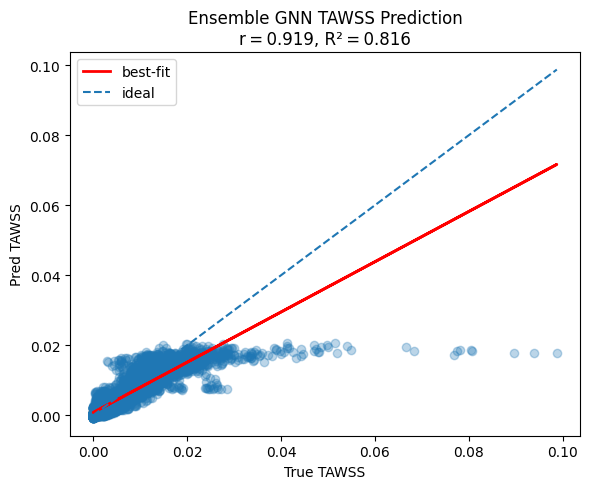


OSI
  slope      = 0.260
  intercept  = 0.016
  Pearson r  = 0.343
  R²         = -0.072


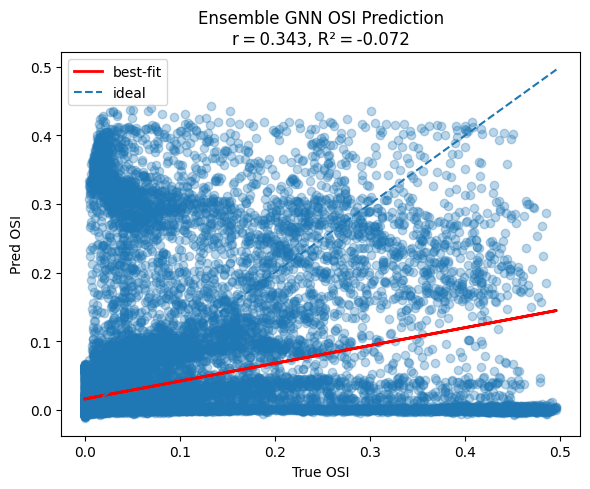

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 1.  Ensemble predictions ────────────────────────────────────────────
all_preds, all_trues = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        # gather each model’s output
        outs = [m(batch) for m in ensemble_models]          # list[Tensor, …]
        mean_out = torch.stack(outs, dim=0).mean(dim=0)     # [batch_size, n_targets]

        all_preds.append(mean_out.cpu())
        all_trues.append(batch.y.cpu())

preds = torch.cat(all_preds, dim=0)
trues = torch.cat(all_trues, dim=0)

# ── 2.  Un‑normalize ────────────────────────────────────────────────────
preds = preds * y_std + y_mean
trues = trues * y_std + y_mean

preds = preds.numpy()
trues = trues.numpy()

labels = ["TAWSS", "OSI"]

for i, lbl in enumerate(labels):
    y_true = trues[:, i]
    y_pred = preds[:, i]

    # ---- least‑squares line ----
    slope, intercept = np.polyfit(y_true, y_pred, deg=1)
    line = slope * y_true + intercept

    # ---- metrics ----
    r,  _ = pearsonr(y_true, y_pred)
    r2     = r2_score(y_true, y_pred)

    print(f"\n{lbl}")
    print(f"  slope      = {slope:.3f}")
    print(f"  intercept  = {intercept:.3f}")
    print(f"  Pearson r  = {r:.3f}")
    print(f"  R²         = {r2:.3f}")

    # ---- plot ----
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot(y_true, line, color="red", linewidth=2, label="best‑fit")   # ← red line
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], linestyle="--", label="ideal")          # y = x
    plt.xlabel(f"True {lbl}")
    plt.ylabel(f"Pred {lbl}")
    plt.title(f"Ensemble GNN {lbl} Prediction\n"
              f"r = {r:.3f}, R² = {r2:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()
